In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


/Users/Martin/opt/anaconda3/envs/pytorch2/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/Martin/opt/anaconda3/envs/pytorch2/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <9B280146-BBD7-3F77-9873-F9740F2A5329> /Users/Martin/opt/anaconda3/envs/pytorch2/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <F7AE755F-2C08-3F6F-BD86-4A77C452FBB5> /Users/Martin/opt/anaconda3/envs/pytorch2/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
class ISICDataset(Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_dir, img_name)
        
        # Modify the mask name to match the image name
        mask_name = img_name.replace(".jpg", "_Segmentation.png")
        mask_path = os.path.join(self.masks_dir, mask_name)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply transforms
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Convert mask to binary (0 and 1) if needed
        mask = (np.array(mask) > 0).astype(np.float32)
        mask = torch.tensor(mask, dtype=torch.float32)  # Add channel dimension for mask

        return image, mask


In [3]:
# Transform for images
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform for masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [4]:
data_dir = "../DATA"

images_dir = f"{data_dir}/TrainingImages"
masks_dir = f"{data_dir}/TrainingMasks"

# Initialize dataset with separate transforms
dataset = ISICDataset(images_dir=images_dir, masks_dir=masks_dir, image_transform=image_transform, mask_transform=mask_transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Display the first batch for verification
images, masks = next(iter(dataloader))
print(f"Image batch shape: {images.shape}")
print(f"Mask batch shape: {masks.shape}")


Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..1.6465361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2829131..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1247058..2.2042704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4558606..1.4831933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0549891..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0549891..1.

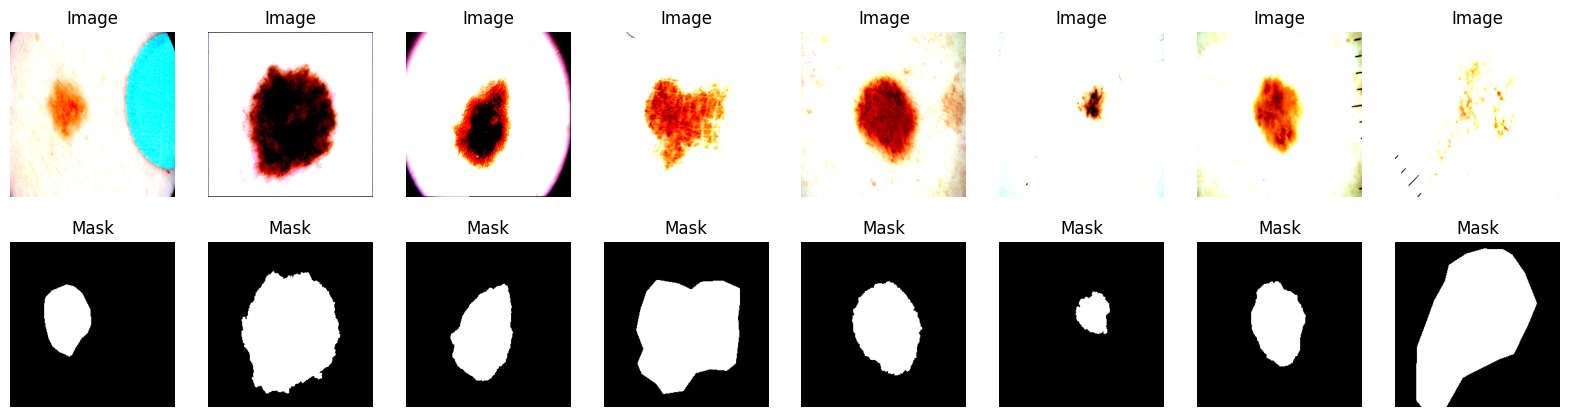

In [ ]:
import matplotlib.pyplot as plt

# function that displays batch of images and masks
def show_batch(images, masks):
    fig, ax = plt.subplots(2, 8, figsize=(20, 5))
    for i in range(8):
        ax[0][i].imshow(images[i].permute(1, 2, 0))
        ax[0][i].set_title("Image")
        ax[0][i].axis("off")
        ax[1][i].imshow(masks[i][0], cmap="gray")
        ax[1][i].set_title("Mask")
        ax[1][i].axis("off")
    plt.show()

show_batch(images, masks)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder: Downsampling path
        self.encoder1 = DoubleConv(in_channels, 64)
        self.encoder2 = DoubleConv(64, 128)
        self.encoder3 = DoubleConv(128, 256)
        self.encoder4 = DoubleConv(256, 512)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder: Upsampling path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(128, 64)
        
        # Output layer
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, 2))
        enc3 = self.encoder3(F.max_pool2d(enc2, 2))
        enc4 = self.encoder4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder with skip connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        # Output layer
        output = self.output_conv(dec1)
        return output


In [ ]:
# Initialize the model
model = UNet(in_channels=3, out_channels=1)

# Create a dummy input tensor and pass it through the model
input_tensor = torch.randn(8, 3, 256, 256)
output = model(input_tensor)

print(f"Output shape: {output.shape}")


Output shape: torch.Size([8, 1, 256, 256])


In [ ]:
# Paths
train_images_dir = f"{data_dir}/TrainingImages"
train_masks_dir = f"{data_dir}/TrainingMasks"
test_images_dir = f"{data_dir}/TestImages"
test_masks_dir = f"{data_dir}/TestMasks"

# Datasets
train_dataset = ISICDataset(images_dir=train_images_dir, masks_dir=train_masks_dir,
                            image_transform=image_transform, mask_transform=mask_transform)
test_dataset = ISICDataset(images_dir=test_images_dir, masks_dir=test_masks_dir,
                           image_transform=image_transform, mask_transform=mask_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
import torch.optim as optim

# Model, loss function, and optimizer
model = UNet(in_channels=3, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0

#     for images, masks in train_loader:
#         images, masks = images.to(device), masks.to(device)
        
#         outputs = model(images)
#         loss = criterion(outputs, masks)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         train_loss += loss.item()
    
#     # Print training loss for each epoch
#     avg_train_loss = train_loss / len(train_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

#     # Evaluate on the test set
#     model.eval()
#     test_loss = 0
#     with torch.no_grad():
#         for images, masks in test_loader:
#             images, masks = images.to(device), masks.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, masks)
#             test_loss += loss.item()
    
#     avg_test_loss = test_loss / len(test_loader)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_test_loss:.4f}")


In [12]:
# load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load("../Models/unet_skin_lesion_segmentation.pth", map_location=torch.device(device)))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6650109..1.9577874].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5280112..1.8508403].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54954237..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3354341..1.1585187].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4229691..1.6988237].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.03571

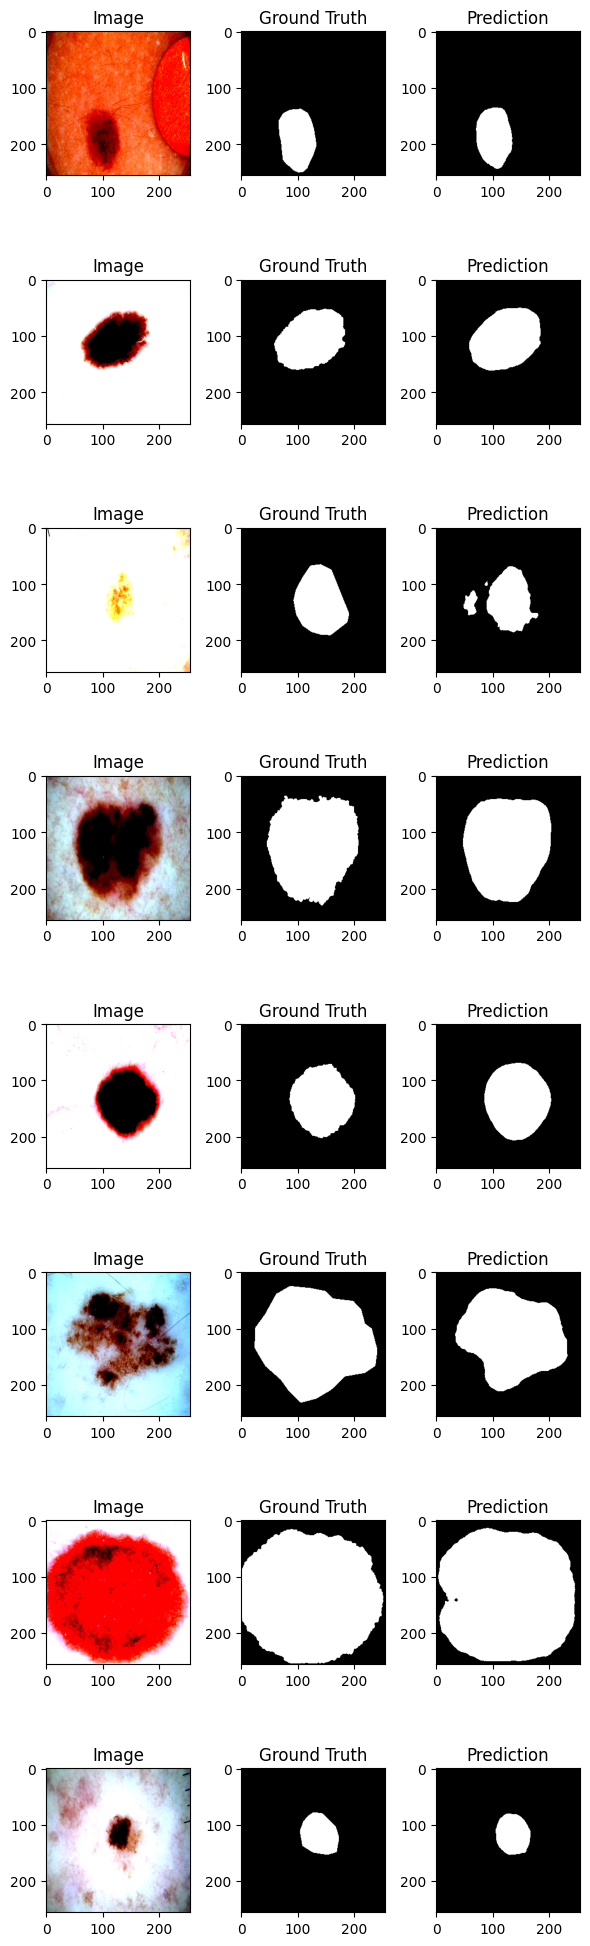

In [ ]:
def visualize_predictions(images, masks, outputs):
    images = images.cpu().numpy().transpose(0, 2, 3, 1)
    masks = masks.cpu().numpy()
    outputs = torch.sigmoid(outputs).detach().cpu().numpy()

    num_images = len(images)
    fig, ax = plt.subplots(num_images, 3, figsize=(6, 20))
    for i in range(num_images):
        ax[i][0].imshow(images[i])
        ax[i][0].set_title("Image")
        ax[i][1].imshow(masks[i][0], cmap="gray")
        ax[i][1].set_title("Ground Truth")
        ax[i][2].imshow(outputs[i][0] > 0.5, cmap="gray")
        ax[i][2].set_title("Prediction")
    
    plt.tight_layout()
    plt.show()

# Visualization of predictions
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)
outputs = model(images)
visualize_predictions(images, masks, outputs)

In [ ]:
# metrics Dice Coefficient and Intersection over Union
def dice_coefficient(outputs, masks):
    smooth = 1e-6
    outputs = outputs.view(-1)
    masks = masks.view(-1)
    intersection = (outputs * masks).sum()
    dice = (2. * intersection + smooth) / (outputs.sum() + masks.sum() + smooth)
    return dice

def intersection_over_union(outputs, masks):
    smooth = 1e-6
    outputs = outputs.view(-1)
    masks = masks.view(-1)
    intersection = (outputs * masks).sum()
    union = outputs.sum() + masks.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

# Evaluate the model on the test set
model.eval()
test_dice = 0
test_iou = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_dice += dice_coefficient(torch.sigmoid(outputs), masks).item()
        test_iou += intersection_over_union(torch.sigmoid(outputs), masks).item()

# Dice Coefficient and Intersection over Union
avg_dice = test_dice / len(test_loader)
avg_iou = test_iou / len(test_loader)
print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average Intersection over Union: {avg_iou:.4f}")

Average Dice Coefficient: 0.7942
Average Intersection over Union: 0.6613
